In [ ]:
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
!pip install python_wtd
import copy
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import pandas_datareader as web

from sklearn.preprocessing import LabelEncoder
import matplotlib


#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn import tree
#from sklearn.neural_network import MLPClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB

# **Import Dataset**

In [ ]:
df = web.DataReader('^DJI', data_source = 'yahoo', start = '2000-01-01')
print(df.head())
print('\n')
print(df.shape)

                    High           Low          Open         Close     Volume     Adj Close
Date                                                                                       
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570


(5178, 6)


In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,11522.009766,11305.690430,11501.849609,11357.509766,169750000,11357.509766
2000-01-04,11350.059570,10986.450195,11349.750000,10997.929688,178420000,10997.929688
2000-01-05,11215.099609,10938.669922,10989.370117,11122.650391,203190000,11122.650391
2000-01-06,11313.450195,11098.450195,11113.370117,11253.259766,176550000,11253.259766
2000-01-07,11528.139648,11239.919922,11247.059570,11522.559570,184900000,11522.559570


In [ ]:
wtd = WTD(api_key= 'key here')
my_dict = wtd.historical('^DJI',output='dict')
df = wtd.historical('^DJI',order='oldest')
#df = wtd.historical('^DJI',date_from='2000',date_to=datetime.date.today())
print(df.head())
print('\n')
print(df.shape)


In [ ]:
# Inspect the index 
df.index

# Inspect the columns
df.columns

# Select only the last 10 observations of `Close`
ts = df['Close'][-10:]

# Check the type of `ts` 
type(ts)


pandas.core.series.Series

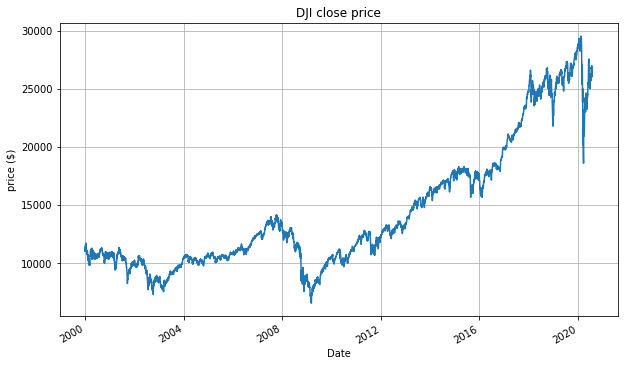

In [ ]:
# Plot the closing prices for `aapl`
df['Close'].plot(grid=True, figsize=(10, 6))
plt.title('DJI close price')
plt.ylabel('price ($)')
# Show the plot
plt.show()

In [ ]:
DATA = df
ti= copy.deepcopy(DATA)

####**Simple Moving Average (SMA)**
SMA is calculated by adding the price of an instrument over a number of time periods and then dividing the sum by the number of time periods. The SMA is basically the average price of the given time period, with equal weighting given to the price of each period.

Formula: SMA = ( Sum ( Price, n ) ) / n    
Where: n = Time Period

In [ ]:
ti['SMA_10'] = (sum(ti.Close, 10))/10
ti['SMA_20'] = (sum(ti.Close, 20))/20
ti['SMA_50'] = (sum(ti.Close, 50))/50
ti['SMA_100'] = (sum(ti.Close, 100))/100
ti['SMA_200'] = (sum(ti.Close, 200))/200

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

In [ ]:
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
Date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441327e+06  3.720664e+06  1.488266e+06   

                  SMA_100        SMA_200

### **Exponential movine average (EMA)**
The three basic steps to calculating the EMA are:
- Calculate the SMA.
- Calculate the multiplier for smoothing/weighting factor for the previous EMA.
- Calculate the current EMA.

The multiplier for smoothing (weighting) the EMA typically follows the formula:  
- [2 ÷ (selected time period + 1)] 

So, for a 20-day moving average, the multiplier would be [2/(20+1)]= 0.0952.

To calculate the EMA, the following formula is used: 

- [Closing price-EMA (previous day)] x multiplier + EMA (previous day)

In [ ]:
ti['ema_10'] = ti.Close.ewm(span=10).mean().fillna(0)
ti['ema_20'] = ti.Close.ewm(span=20).mean().fillna(0)
ti['ema_50'] = ti.Close.ewm(span=50).mean().fillna(0)
ti['ema_100'] = ti.Close.ewm(span=100).mean().fillna(0)
ti['ema_200'] = ti.Close.ewm(span=200).mean().fillna(0)


In [ ]:
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
Date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441327e+06  3.720664e+06  1.488266e+06   

                  SMA_100        SMA_200

### **Average true range (ATR)** 

ATR measures market volatility. It is typically derived from the 14-day moving average of a series of true range indicators.

### True Range 

Highest of:
 - today's h - l
 - abs(h - y'day close)
 - abs(l - y'day close)

 ATR exp moving average is typocally 14 of that true range

In [ ]:
ti['ATR'] = talib.ATR(ti['High'].values, 
                      ti['Low'].values, 
                      ti['Close'].values, 
                      timeperiod=14)

In [ ]:
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
Date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441325e+06  3.720663e+06  1.488266e+06   

                  SMA_100        SMA_200

###**Average Directional Index (ADX)**
ADX indicates the strength of a trend in price time series. It is a combination of the negative and positive directional movements indicators computed over a period of n past days corresponding to the input window length (typically 14 days) 


In [ ]:
ti['ADX'] = talib.ADX(ti.High, ti.Low, ti.Close, timeperiod=14)

In [ ]:
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
Date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441325e+06  3.720663e+06  1.488266e+06   

                  SMA_100        SMA_200

### **Commodity Channel Index (CCI)** 
CCI is an oscillator used to deter- mine whether a stock is overbought or oversold. It assesses the relationship between an asset price, its moving average and de- viations from that average:  

- CCI = (typical price − ma) / (0.015 * mean deviation)
- typical price = (high + low + close) / 3
- p = number of periods (20 commonly used)
- ma = moving average
- moving average = typical price / p
- mean deviation = (typical price - MA) / p

In [ ]:
#Calculation of Commodity Channel Index
tp = (ti['High'] + ti['Low'] + ti['Close']) / 3
ma = tp / 20
md = (tp - ma) / 20
ti['CCI'] = (tp-ma)/(0.015 * md)

In [ ]:
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
Date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441325e+06  3.720663e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441325e+06  3.720663e+06  1.488266e+06   

                  SMA_100        SMA_200

### **Price rate-of-change (ROC)** 
ROC measures the percentage change in price between the current price and the price a certain number of periods ago. 

ROC = [(Close price today - Close price “n” day’s ago) / Close price “n” day’s ago))]



In [ ]:
ti['ROC'] = ((ti['Close'] - ti['Close'].shift(12)) / 
                    (ti['Close'].shift(12)))*100
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
Date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441327e+06  3.720664e+06  1.488266e+06   

                  SMA_100        SMA_200

### **Relative Strength Index (RSI)** 
RSI compares the size of recent gains to recent losses, it is intended to reveal the strength or weak- ness of a price trend from a range of closing prices over a time period.  


In [ ]:
ti['rsi'] = talib.RSI(ti.Close.values, timeperiod = 14)
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
Date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441327e+06  3.720664e+06  1.488266e+06   

                  SMA_100        SMA_200

### **William’s %R** 
This shows the relationship between the current closing price and the high and low prices over the latest n days equal to the input window length


In [ ]:
ti['Williams %R'] = talib.WILLR(ti.High.values, 
                                     ti.Low.values, 
                                     ti.Close.values, 14)
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
Date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441327e+06  3.720664e+06  1.488266e+06   

                  SMA_100        SMA_200

### **Stochastic %K** 
It compares a close price and its price interval during a period of n past days and gives a signal meaning that a stock is oversold or over- bought: 



In [ ]:
ti['SO%K'] = ((ti['Close'] - 
               ti['Low']) / 
              (ti['High'] - ti['Low']))
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
Date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441327e+06  3.720664e+06  1.488266e+06   

                  SMA_100        SMA_200

In [ ]:
ti.index.name = 'date' # setting the index column as 'date'
print(ti.head())
print('\n')
print(ti.columns)
print('\n')
print(ti.index)

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
date                                                                                                                                    
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766  7.441327e+06  3.720664e+06  1.488266e+06   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570  7.441327e+06  3.720664e+06  1.488266e+06   

                  SMA_100        SMA_200

In [ ]:
print(ti.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5178 entries, 2000-01-03 to 2020-07-31
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   High         5178 non-null   float64
 1   Low          5178 non-null   float64
 2   Open         5178 non-null   float64
 3   Close        5178 non-null   float64
 4   Volume       5178 non-null   int64  
 5   Adj Close    5178 non-null   float64
 6   SMA_10       5178 non-null   float64
 7   SMA_20       5178 non-null   float64
 8   SMA_50       5178 non-null   float64
 9   SMA_100      5178 non-null   float64
 10  SMA_200      5178 non-null   float64
 11  ema_10       5178 non-null   float64
 12  ema_20       5178 non-null   float64
 13  ema_50       5178 non-null   float64
 14  ema_100      5178 non-null   float64
 15  ema_200      5178 non-null   float64
 16  ATR          5164 non-null   float64
 17  ADX          5151 non-null   float64
 18  CCI          5178 non-null   f

### Data Quality Checks:

Checked the statistics of individual columns in the dataframe.

As you can see below there are no outliers in any of the columns, however, some of the columns have NaN values

In [ ]:
# Check the statistics of the columns of the merged dataframe and check for outliers
print(ti.describe())

               High           Low          Open         Close        Volume     Adj Close        SMA_10        SMA_20        SMA_50       SMA_100  \
count   5178.000000   5178.000000   5178.000000   5178.000000  5.178000e+03   5178.000000  5.178000e+03  5.178000e+03  5.178000e+03  5.178000e+03   
mean   14453.908386  14279.493836  14368.839374  14371.039125  2.252508e+08  14371.039125  7.441325e+06  3.720663e+06  1.488266e+06  7.441334e+05   
std     5509.898204   5473.788222   5493.280768   5493.095015  1.110708e+08   5493.095015  7.255704e-07  3.627852e-07  6.659600e-08  3.329800e-08   
min     6709.609863   6469.950195   6547.009766   6547.049805  8.410000e+06   6547.049805  7.441325e+06  3.720663e+06  1.488266e+06  7.441334e+05   
25%    10501.612793  10375.415039  10440.645020  10441.932861  1.466375e+08  10441.932861  7.441325e+06  3.720663e+06  1.488266e+06  7.441334e+05   
50%    12306.145020  12167.020020  12244.679688  12247.774902  2.177000e+08  12247.774902  7.441325e+06  3

In [ ]:
ti = ti.dropna()
print(ti.head())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
date                                                                                                                                    
2000-02-10  10738.250000  10606.400391  10697.919922  10643.629883  156390000  10643.629883  7.441327e+06  3.720664e+06  1.488266e+06   
2000-02-11  10638.639648  10356.959961  10638.639648  10425.209961  193540000  10425.209961  7.441327e+06  3.720664e+06  1.488266e+06   
2000-02-14  10549.000000  10430.799805  10431.650391  10519.839844  167240000  10519.839844  7.441327e+06  3.720664e+06  1.488266e+06   
2000-02-15  10763.070312  10494.480469  10520.150391  10718.089844  183320000  10718.089844  7.441327e+06  3.720664e+06  1.488266e+06   
2000-02-16  10741.669922  10561.410156  10711.820312  10561.410156  163280000  10561.410156  7.441327e+06  3.720664e+06  1.488266e+06   

                  SMA_100        SMA_200

In [ ]:
print('Total dataset has {} samples, and {} features.'.format(ti.shape[0], ti.shape[1]))

Total dataset has 5151 samples, and 23 features.


Now, we will plot a heat map and a scatter matrix to see the correlation of the columns with each other.

We can see the heat map with pearson correlation values in the plot below.

This provides a better understanding to see if there are any dependant variables or if any of the variables are highly correlated.

Some variables Subjectivity, Objectivity are negatively correlated. There are very few variables which seem to have a very high correlation. Thus, at this point we can conclude that we do not need any sort of dimensionality reduction technique to be applied.

In [ ]:
#import seaborn as sns
#colormap =plt.cm.afmhot
#plt.figure(figsize=(16,12))
#plt.title('Pearson correlation of continuous features', y=1.05, size=15)
#sns.heatmap(ti.corr(),linewidths=0.1,vmax=1.0, square=True, 
#            cmap=colormap, linecolor='white', annot=True)
#plt.show()

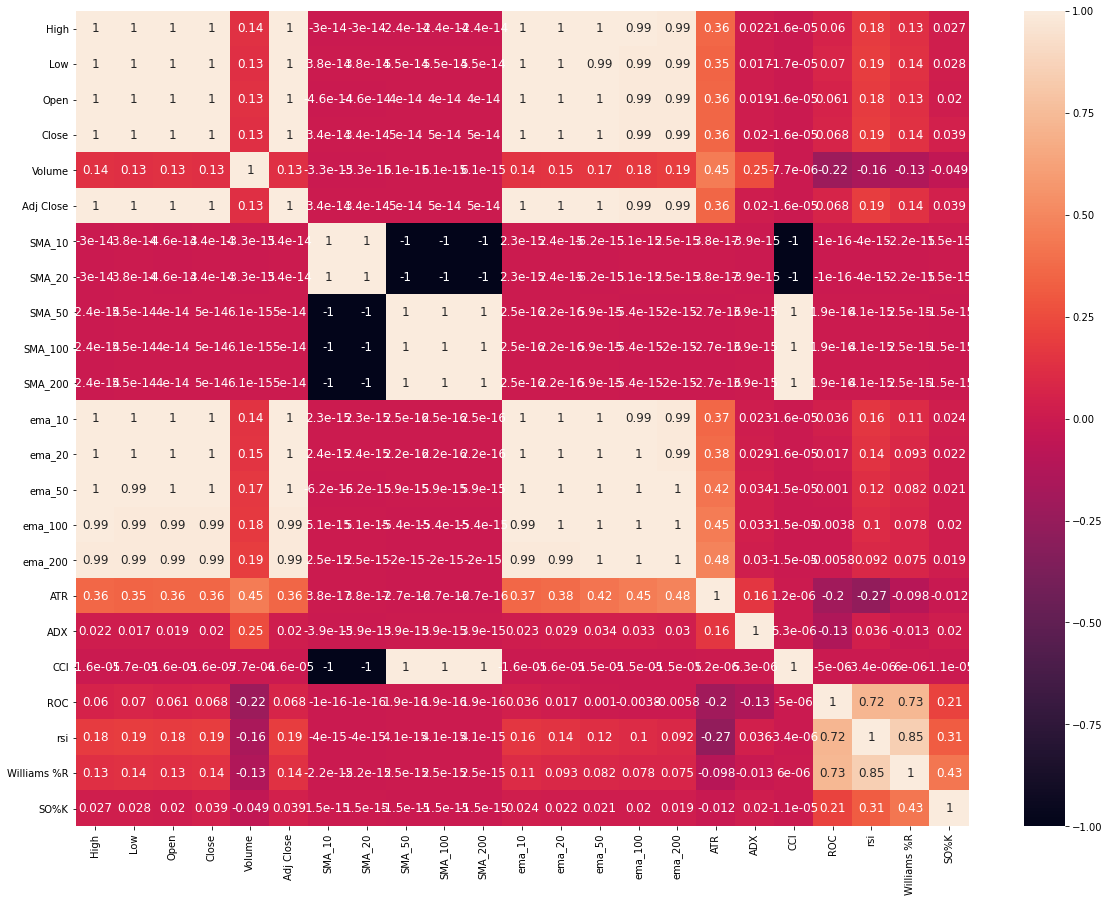

In [ ]:
import seaborn as sns
corr = ti.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
ti.tail()

In [ ]:
ti['pred_price'] = np.where(ti['Close'].shift(-1) > ti['Close'], 0, 1)
print(ti.tail())

                    High           Low          Open         Close     Volume     Adj Close        SMA_10        SMA_20        SMA_50  \
date                                                                                                                                    
2020-07-27  26625.460938  26426.919922  26447.669922  26584.769531  400930000  26584.769531  7.441327e+06  3.720664e+06  1.488266e+06   
2020-07-28  26556.839844  26361.710938  26529.449219  26379.279297  361090000  26379.279297  7.441327e+06  3.720664e+06  1.488266e+06   
2020-07-29  26602.449219  26375.390625  26388.439453  26539.570312  347580000  26539.570312  7.441327e+06  3.720664e+06  1.488266e+06   
2020-07-30  26374.929688  25992.279297  26367.419922  26313.650391  351540000  26313.650391  7.441327e+06  3.720664e+06  1.488266e+06   
2020-07-31  26409.330078  26013.589844  26409.330078  26083.169922  249917744  26083.169922  7.441327e+06  3.720664e+06  1.488266e+06   

                  SMA_100        SMA_200

In [ ]:
ti['pred_price'].unique()

array([0, 1])

- Recheck the dataframe to see if the dataset is ready for train.
- Split the ti dataframe to inputs(X) and outputs(y)

In our dataset, we have all the columns except pred_price as inputs and the pred_price column output.

We are not shuffling data before splitting as we really want to predict prices in future by training our model on past data. We have to be careful here while training and evaluating time series data as there can be a high chance of overfitting (and don’t use cross-validation for evaluation).

As this is a time series, it is important we do not randomly pick training and testing samples.


In [ ]:
#ti = ti.fillna(0)

In [ ]:
y = ti['pred_price']
x = ti.drop(columns = ['pred_price', 'Close', 'Adj Close', 'Volume'])

In [ ]:
train_x = x[: '2014-12-31'] 
test_x  = x['2015-01-01':] 
print('Observations: %d' % (len(x)))
print('Train Dataset:',train_x.shape)
print('Test Dataset:', test_x.shape)

Observations: 5151
Train Dataset: (3746, 20)
Test Dataset: (1405, 20)


In [ ]:
train_y = y[: '2014-12-31'] 
test_y  = y['2015-01-01': ] 
print('Observations: %d' % (len(y)))
print('Train Dataset:',train_y.shape)
print('Test Dataset:', test_y.shape)

Observations: 5151
Train Dataset: (3746,)
Test Dataset: (1405,)


<Figure size 864x432 with 0 Axes>

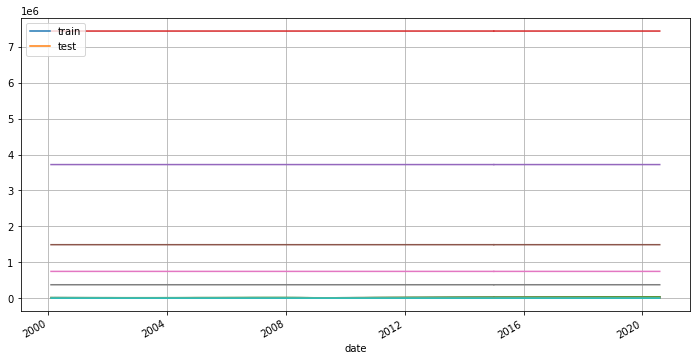

In [ ]:
plt.figure(figsize=(12, 6))
ax = train_x.plot(grid=True, figsize=(12, 6))
test_x.plot(ax=ax, grid=True)
plt.legend(['train', 'test']);
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1)) # scaling down the values
train_x_scaled = scaler.fit_transform(train_x)
print(train_x_scaled)

[[0.35358056 0.35756612 0.3609622  ... 0.32456742 0.04897975 0.28236331]
 [0.34483809 0.3360038  0.3558072  ... 0.25601062 0.08455366 0.24229649]
 [0.33697071 0.34238672 0.33780746 ... 0.3157681  0.20178888 0.75329858]
 ...
 [0.997331   0.99855377 1.         ... 0.73394046 0.93703899 0.3236946 ]
 [0.99399415 0.99320547 0.9989947  ... 0.69556669 0.88378837 0.31028939]
 [0.99471394 0.98120562 0.99487634 ... 0.59391814 0.72932725 0.00984733]]


In [ ]:
# Time for Classification Models
import time
from sklearn import svm

dict_classifiers = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=5000),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": svm.SVC(gamma = 'auto'),
    "Gradient Boosting Classifier": XGBClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Neural Net": MLPClassifier(solver='adam', alpha=0.0001,learning_rate='constant', learning_rate_init=0.001),
    "Naive Bayes": GaussianNB()
}

In [ ]:
no_classifiers = len(dict_classifiers.keys())

def batch_classify(train_x_scaled, train_y, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), 
                              columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.process_time()
        classifier.fit(train_x_scaled, train_y)
        t_end = time.process_time()
        t_diff = t_end - t_start
        train_score = classifier.score(train_x_scaled, train_y)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [ ]:
df_results = batch_classify(train_x_scaled, train_y)
print(df_results.sort_values(by='train_score', ascending=True))

trained Logistic Regression in 0.09 s
trained Nearest Neighbors in 0.02 s
trained Support Vector Machine in 0.75 s
trained Gradient Boosting Classifier in 0.36 s
trained Decision Tree in 0.10 s
trained Random Forest in 1.14 s
trained Neural Net in 1.84 s
trained Naive Bayes in 0.00 s
                     classifier  train_score  training_time
2        Support Vector Machine     0.527763       0.746196
7                   Naive Bayes     0.529098       0.004754
0           Logistic Regression     0.541644       0.089432
6                    Neural Net     0.553123       1.843098
1             Nearest Neighbors     0.699146       0.017354
3  Gradient Boosting Classifier     0.699413       0.362960
4                 Decision Tree     1.000000       0.097326
5                 Random Forest     1.000000       1.141966


In [ ]:
# Use Cross-validation.

# Logistic Regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=5000)
log_scores = cross_val_score(log_reg, train_x_scaled, train_y, cv=5)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = svm.SVC(gamma='auto')
svc_scores = cross_val_score(svc_clf, train_x_scaled, train_y, cv=5)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, train_x_scaled, train_y, cv=5)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, train_x_scaled, train_y, cv=5)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = XGBClassifier()
grad_scores = cross_val_score(grad_clf, train_x_scaled, train_y, cv=5)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=100)
rand_scores = cross_val_score(rand_clf, train_x_scaled, train_y, cv=5)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=0.0001, max_iter=5000)
neural_scores = cross_val_score(neural_clf, train_x_scaled, train_y, cv=5)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, train_x_scaled, train_y, cv=5)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'XGBoost CLF', 'Rand FC', 'Neural Classifier', 'Naive Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

In [ ]:
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
1,SVC,0.519485
0,Logistic Reg.,0.503733
3,Dec Tree,0.491730
6,Neural Classifier,0.484244
7,Naive Bayes,0.484244
2,KNN,0.458086
4,XGBoost CLF,0.457288
5,Rand FC,0.440464


In [ ]:
# estimate accuracy on validation dataset
test_x_scaled = scaler.transform(test_x)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
SVC = svm.SVC(gamma = 'auto')
SVC.fit(train_x_scaled, train_y)
predictions = SVC.predict(test_x_scaled)
print("accuracy score:")
print(accuracy_score(test_y, predictions))
print("confusion matrix: ")
print(confusion_matrix(test_y, predictions))
print("classification report: ")
print(classification_report(test_y, predictions))

accuracy score:
0.5387900355871886
confusion matrix: 
[[757   0]
 [648   0]]
classification report: 
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       757
           1       0.00      0.00      0.00       648

    accuracy                           0.54      1405
   macro avg       0.27      0.50      0.35      1405
weighted avg       0.29      0.54      0.38      1405



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
xgb = XGBClassifier()
xgb.fit(train_x_scaled, train_y)
predictions = xgb.predict(test_x_scaled)
print("accuracy score:")
print(accuracy_score(test_y, predictions))
print("confusion matrix: ")
print(confusion_matrix(test_y, predictions))
print("classification report: ")
print(classification_report(test_y, predictions))

accuracy score:
0.46548042704626336
confusion matrix: 
[[107 650]
 [101 547]]
classification report: 
              precision    recall  f1-score   support

           0       0.51      0.14      0.22       757
           1       0.46      0.84      0.59       648

    accuracy                           0.47      1405
   macro avg       0.49      0.49      0.41      1405
weighted avg       0.49      0.47      0.39      1405



roc auc is :0.47833798131024025


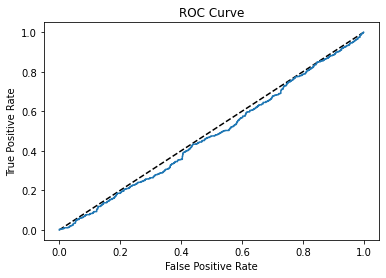

In [ ]:
# Generating the ROC curve
y_pred_proba = xgb.predict_proba(test_x_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
from sklearn.model_selection import KFold
# AUC score using cross validation
kfold_val = KFold(n_splits=5)
auc_score = cross_val_score(xgb, test_x_scaled, test_y, cv=5, scoring='roc_auc')
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

AUC using cross val: [0.40326032 0.41156393 0.44696893 0.46544778 0.51152591]
Mean AUC score is: 0.44775337158484596


In [ ]:
# XGBoost on Stock Price dataset, Tune n_estimators and max_depth
matplotlib.use('Agg')
model = XGBClassifier()
n_estimators = [150, 200, 250, 450, 500]
max_depth = [1, 2, 3, 4, 5, 6]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(train_x_scaled, train_y)
        y_pred = model.predict(test_x_scaled)
        score = accuracy_score(test_y, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))

[1, 2, 3, 4, 5, 6]
Score is 0.47046263345195727 at depth of 1 and estimator 150
Score is 0.47259786476868326 at depth of 2 and estimator 150
Score is 0.4740213523131673 at depth of 3 and estimator 150
Score is 0.4718861209964413 at depth of 4 and estimator 150
Score is 0.47259786476868326 at depth of 5 and estimator 150
Score is 0.4711743772241993 at depth of 6 and estimator 150
Score is 0.47686832740213525 at depth of 1 and estimator 200
Score is 0.47473309608540926 at depth of 2 and estimator 200
Score is 0.4761565836298932 at depth of 3 and estimator 200
Score is 0.4740213523131673 at depth of 4 and estimator 200
Score is 0.47330960854092524 at depth of 5 and estimator 200
Score is 0.4718861209964413 at depth of 6 and estimator 200
Score is 0.47544483985765124 at depth of 1 and estimator 250
Score is 0.47259786476868326 at depth of 2 and estimator 250
Score is 0.47330960854092524 at depth of 3 and estimator 250
Score is 0.47259786476868326 at depth of 4 and estimator 250
Score is 0.

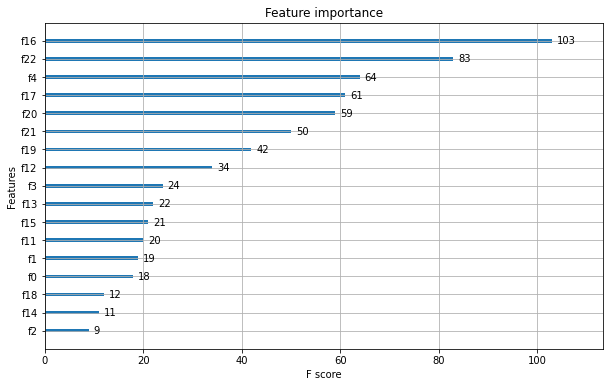

In [ ]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (10, 6)
plot_importance(xgb)
plt.show()

In [ ]:
log_reg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_reg = LogisticRegression(solver='lbfgs', max_iter=5000)
log_reg.fit(train_x_scaled, train_y)
predictions = log_reg.predict(test_x_scaled)
print("accuracy score:")
print(accuracy_score(test_y, predictions))
print("confusion matrix: ")
print(confusion_matrix(test_y, predictions))
print("classification report: ")
print(classification_report(test_y, predictions))

accuracy score:
0.4830113257828115
confusion matrix: 
[[351 336]
 [440 374]]
classification report: 
              precision    recall  f1-score   support

           0       0.44      0.51      0.47       687
           1       0.53      0.46      0.49       814

    accuracy                           0.48      1501
   macro avg       0.49      0.49      0.48      1501
weighted avg       0.49      0.48      0.48      1501



In [ ]:
# The estimated coefficients will all be around 1:
print(log_reg.coef_)

[[-0.00131682 -0.12419522 -0.05205014 -0.19117123 -0.39489303 -0.19117123
   0.          0.          0.          0.          0.         -0.06980024
   0.02572431  0.30129347  0.27329359 -0.1083596  -0.53756419  0.1960773
   0.26932871 -0.23191706 -0.02645258  0.11178317 -0.50046438]]


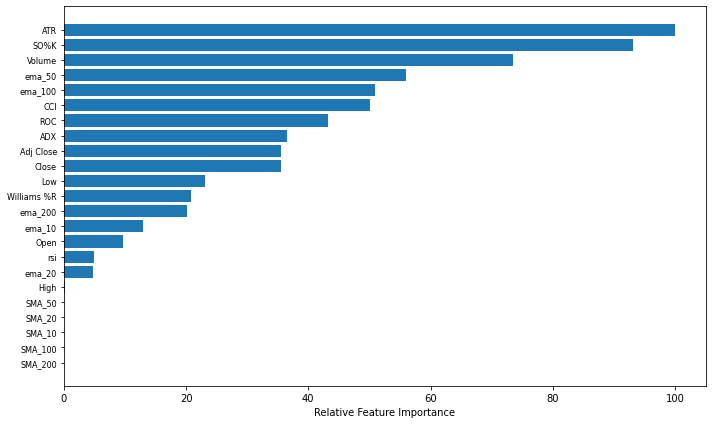

In [ ]:
feature_importance = abs(log_reg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(train_x.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

roc auc is :0.4879420905621779


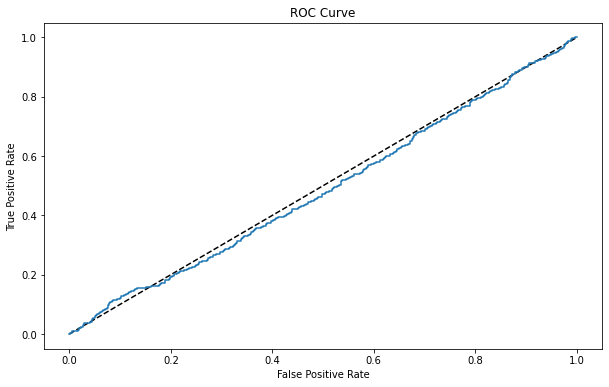

In [ ]:
# Generating the ROC curve
y_pred_proba = log_reg.predict_proba(test_x_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=5000)
n_estimators = [150, 200, 250, 450, 500]
max_depth = [1, 2, 3, 4, 5, 6]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = LogisticRegression(solver='lbfgs', max_iter=5000)
        model.fit(train_x_scaled, train_y)
        y_pred = model.predict(test_x_scaled)
        score = accuracy_score(test_y, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))

[1, 2, 3, 4, 5, 6]
Score is 0.4830113257828115 at depth of 1 and estimator 150
Score is 0.4830113257828115 at depth of 2 and estimator 150
Score is 0.4830113257828115 at depth of 3 and estimator 150
Score is 0.4830113257828115 at depth of 4 and estimator 150
Score is 0.4830113257828115 at depth of 5 and estimator 150
Score is 0.4830113257828115 at depth of 6 and estimator 150
Score is 0.4830113257828115 at depth of 1 and estimator 200
Score is 0.4830113257828115 at depth of 2 and estimator 200
Score is 0.4830113257828115 at depth of 3 and estimator 200
Score is 0.4830113257828115 at depth of 4 and estimator 200
Score is 0.4830113257828115 at depth of 5 and estimator 200
Score is 0.4830113257828115 at depth of 6 and estimator 200
Score is 0.4830113257828115 at depth of 1 and estimator 250
Score is 0.4830113257828115 at depth of 2 and estimator 250
Score is 0.4830113257828115 at depth of 3 and estimator 250
Score is 0.4830113257828115 at depth of 4 and estimator 250
Score is 0.4830113257

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_x_scaled, train_y)
predictions = rf.predict(test_x_scaled)
print("accuracy score:")
print(accuracy_score(test_y, predictions))
print("confusion matrix: ")
print(confusion_matrix(test_y, predictions))
print("classification report: ")
print(classification_report(test_y, predictions))

accuracy score:
0.5263157894736842
confusion matrix: 
[[101 586]
 [125 689]]
classification report: 
              precision    recall  f1-score   support

           0       0.45      0.15      0.22       687
           1       0.54      0.85      0.66       814

    accuracy                           0.53      1501
   macro avg       0.49      0.50      0.44      1501
weighted avg       0.50      0.53      0.46      1501



In [ ]:
daily_return = ti['Close'].pct_change()
sharpe_ratio = daily_return.mean() / daily_return.std()
print(sharpe_ratio)

0.01992639254354439


In [ ]:
an_sharpe_ratio = (252**0.5) * sharpe_ratio # annualised sharpe ratio
print(an_sharpe_ratio)

0.31632167518122156


negative Sharpe ratio means the risk-free rate is greater than the portfolio's return, or the portfolio's return is expected to be negative.